In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import time
import itertools
import random
import matplotlib.pyplot as plt

# First we will optimize over the space of the Sub-modular functions.


Here we will have $lp$ be learned tensor and $lq$ be the target tensor. 

We show the problem of $lp$ being sub modular and we want to minimize $\|lp - lq\|^2$. 


## Oracles

### Deterministic Oracle

We just go through all $\binom{n}{2} 2^{n-2}$ constraints and see which ones are violated. 

### Random Oralce

For each of the $\binom{n}{2}$ pairs, we sample $5n$ constraints randomly from the $2^{n-2}$ constraints. We return the violated ones. 

In [ ]:
# input is the tensor with the probability of a binary string given at that index. 
def deterministic_oracle(lp, pi, n, tol = 1e-10, exclude = [], sub = True):
  inequalities = []
  N = 2**(n)
  for i in range(n):
    if i in exclude:
        continue
    for j in range(i):
      if j in exclude:
        continue
      if pi[i] == "id" and pi[j] == "id":
        sgn = -1
      elif pi[i] == "switch" and pi[j] == "switch":
        sgn = -1
      else:
        sgn = 1
      if not sub:
        sgn += -1
      for k in range(N//4): #Think seeing every inequality 4 times. 
        p = format(k,"0"+str(n-2)+"b")
        p11 = list(format(k,"0"+str(n)+"b"))
        p22 = list(format(k,"0"+str(n)+"b"))
        p12 = list(format(k,"0"+str(n)+"b"))
        p21 = list(format(k,"0"+str(n)+"b"))
        idx = 0
        for l in range(n):
          if l != i and l != j:
            p11[l] = p[idx]
            p12[l] = p[idx]
            p21[l] = p[idx]
            p22[l] = p[idx]
            idx += 1
          elif l == i:
            p11[l] = "0"
            p12[l] = "0"
            p21[l] = "1"
            p22[l] = "1"
          elif l == j:
            p11[l] = "0"
            p12[l] = "1"
            p21[l] = "0"
            p22[l] = "1"
        p11 = "".join(p11)
        p12 = "".join(p12)
        p21 = "".join(p21)
        p22 = "".join(p22)
        
        a = int(p11,2)
        b = int(p22,2)
        c = int(p12,2)
        d = int(p21,2)

        # Checks if p11 p22 > p12 p21
        if lp[a]*sgn + lp[b]*sgn + lp[c]*(-sgn) + lp[d]*(-sgn) < tol:
          key = tuple([a,b,c,d,sgn])
          if key not in inequalities:
            inequalities.append(tuple([a,b,c,d,sgn]))

  return inequalities

# input is the tensor with the probability of a binary string given at that index. 
def random_oracle(lp, pi, n, exclude = [], sub = True):
  inequalities = []
  N = 2**(n)
  for i in range(n):
    if i in exclude:
        continue
    for j in range(i):
      if j in exclude:
        continue
      if pi[i] == "id" and pi[j] == "id":
        sgn = -1
      elif pi[i] == "switch" and pi[j] == "switch":
        sgn = -1
      else:
        sgn = 1
      if not sub:
        sgn += -1
      for k in range(5*n):
        index = np.random.randint(N)
        p = format(index,"0"+str(n)+"b")
        p11 = list(p)
        p22 = list(p)
        p12 = list(p)
        p21 = list(p)
        idx = 0
        for l in range(n):
          if l != i and l != j:
            p11[l] = p[idx]
            p12[l] = p[idx]
            p21[l] = p[idx]
            p22[l] = p[idx]
            idx += 1
          elif l == i:
            p11[l] = "0"
            p12[l] = "0"
            p21[l] = "1"
            p22[l] = "1"
          elif l == j:
            p11[l] = "0"
            p12[l] = "1"
            p21[l] = "0"
            p22[l] = "1"
        p11 = "".join(p11)
        p12 = "".join(p12)
        p21 = "".join(p21)
        p22 = "".join(p22)
        
        a = int(p11,2)
        b = int(p22,2)
        c = int(p12,2)
        d = int(p21,2)

        if lp[a]*sgn + lp[b]*sgn + lp[c]*(-sgn) + lp[d]*(-sgn) < 0:
          key = tuple([a,b,c,d,sgn])
          inequalities.append(tuple([a,b,c,d,sgn]))

  return inequalities

def solve(lq, pi, iters = 100, random = False, exclude = [], sub = True):
  N = lq.shape[0]
  n = int(np.log2(N))

  lp = torch.clone(lq)
  Z = dict()

  for iteration in range(iters):
    if random:
      inequalities = random_oracle(lp, pi, n, exclude = exclude, sub = sub)
    else:
      inequalities = deterministic_oracle(lp, pi, n, exclude = exclude, sub = sub)
    max_deficit = 0
    for key in inequalities:
      a,b,c,d,sgn = key

      deficit = lp[a]*sgn + lp[b]*sgn + lp[c]*(-sgn) + lp[d]*(-sgn)
      if deficit < max_deficit:
        max_deficit = deficit 
      if key in Z:
        z = Z[key]
      else:
        z = 0
        Z[key] = 0
      theta = min(deficit/4,z)

      lp[a] += -sgn*theta
      lp[b] += -sgn*theta
      lp[c] += sgn*theta
      lp[d] += sgn*theta

      if abs(z - theta) < 1e-10:
        del Z[key]
      else:
        Z[key] -= theta

    for _ in range(5):
      deletes = []
      for key in Z:
        a,b,c,d,sgn = key

        deficit = lp[a]*sgn + lp[b]*sgn + lp[c]*(-sgn) + lp[d]*(-sgn)
        if deficit < max_deficit:
          max_deficit = deficit 
        z = Z[key]

        theta = min(deficit/4,z)

        lp[a] += -sgn*theta
        lp[b] += -sgn*theta
        lp[c] += sgn*theta
        lp[d] += sgn*theta

        if abs(z - theta) < 1e-10:
          deletes.append(key)
        else:
          Z[key] -= theta
        
      for key in deletes:
        del Z[key]

    # if iteration % 20 == 0:
    #   print((lp-lq).square().sum().sqrt(), max_deficit, len(Z))

    if max_deficit > -1e-6*torch.norm(lq):
      return lp


  return lp

def calc_low_rank_approx(lq,r, iters = 1000, sub = True, random = False):
  N = lq.shape[0]
  n = int(np.log2(N))
  partitions = list(itertools.combinations(list(range(n)), r))
  best_exclude = []
  best_lp = lq
  best_error = float('inf')
  for ex in partitions:
    exclude = list(ex)
    lp = solve(lq, ['id' for _ in range(n)], iters, random = random, exclude = exclude, sub = sub)
    if (lp-lq).square().sum() < best_error:
      best_error = (lp-lq).square().sum() 
      best_lp = lp
      best_exclude = exclude
  return best_error, best_lp, best_exclude

def check_low_rank_approx(lq,r, sub = True):
  N = lq.shape[0]
  n = int(np.log2(N))
  partitions = list(itertools.combinations(list(range(n)), r))
  for ex in partitions:
    exclude = list(ex)
    ineqs = deterministic_oracle(lq, ['id' for _ in range(n)], n, exclude = exclude, sub = sub)
    if len(ineqs) == 0:
      return True
  return False

In [ ]:
volumes = torch.zeros(5,5)
T = 5000000

for i,n in enumerate(range(5,8)):
  for r in range(0,5):
    if r > n-1:
      continue
    for t in tqdm(range(T)):
      lq = torch.randn(2**n)
      if check_low_rank_approx(lq,r):
        volumes[i,r] += 1/T
    print(volumes[i,:])
    


100%|██████████| 5000000/5000000 [7:33:10<00:00, 183.89it/s]


tensor([0., 0., 0., 0., 0.])


  2%|▏         | 101462/5000000 [27:00<21:39:38, 62.82it/s]

In [ ]:
times = torch.zeros(8)
diff = torch.zeros(8)
n = 8

lq = (torch.rand(2**n)+10).log()

for r in range(7):
  t0 = time.time()
  be, blp, bex = calc_low_rank_approx(lq,r, iters = 1000, random = False)
  t1 = time.time()

  times[r] = t1-t0
  diff[r] = torch.norm(lq-blp)/torch.norm(lq)

  print(times[r], diff[r], bex)

  

In [ ]:
time_rand = torch.zeros(20)
time_det = torch.zeros(20)
dif = torch.zeros(20)

for n in range(4,24):

  lq = (torch.rand(2**n)+10).log()
  t0 = time.time()
  lp = solve(lq, ['id' for _ in range(100)], 1500, random = True, exclude = [0,1,2])
  t1 = time.time()
  lp2 = solve(lq, ['id' for _ in range(100)], 1000, random = False, exclude = [0,1,2,3,4,5,6])
  t2 = time.time()

  print(torch.norm(lq))

  time_det[n-4] = t1-t0
  time_rand[n-4] = t2-t1
  dif[n-4] = torch.norm(lq-lp2)/torch.norm(lq)
  print(time_det[n-4], time_rand[n-4], dif[n-4])
  print(deterministic_oracle(lp, ['id' for _ in range(100)], 4, -1e-5*torch.norm(lq) ))
  print(deterministic_oracle(lp2, ['id' for _ in range(100)], 4, -1e-5*torch.norm(lq) ))

Here we assume that we have data $x_1, \ldots, x_k \in \{0,1\}^n$ and then for each $s \in \{0,1\}^n$ we define 

$$ p_s = \frac{| \{ x_i = s \}|}{k}. $$

Then given permutations $\pi_1, \ldots, \pi_m$ and the polytope $L_{\pi} = L_{\pi_1} + \ldots + L_{\pi_m}$, we want to solve the following problem 

$$\text{arg}\min_{q_i \in L_{\pi_i}} D_{KL}(p || q_1 \cdot \ldots \cdot q_m) + \lambda \|\log(q_1) + \ldots + \log(q_m) - \log(p)\|_2^2. $$

We start by noting that 

$$D_{KL}(p || q_1 \cdot \ldots \cdot q_m) = \mathbb{E}_{p}[\log(p) - \log(q)] . $$

Thus, we can rewrite the problem as 

$$\text{arg}\min_{q_i \in L_{\pi_i}}  \frac{\lambda}{2} \|\log(q_1) + \ldots + \log(q_m) - \log(p)\|_2^2 - \mathbb{E}_p\left[\log(q_1) + \ldots + \log(q_m)\right]. $$

For notational convinience we shall define $lq_i = \log(q_i)$. 

Now to run Project and Forget, we will define $f(lq_1, \ldots, lq_m) = \frac{\lambda}{2} \|lq_1 + \ldots + lq_m - lp\|_2^2 - \mathbb{E}_p\left[lq_1 + \ldots + lq_m\right]$. Then to start the algorithm we need to compute $lq^0$ such that $\nabla f (lq^0) = 0$. 

First, we see that the gradient is for $lq_i$ is 

$$\lambda(lq_1 + \ldots + lq_m - lp) - p$$, thus, we see that

$$lq_1 + \ldots + lq_m = lp + \frac{1}{\lambda}p. $$


Thus, we can pick $lq_i = \frac{1}{m} (lp + \frac{1}{\lambda} p).$

Note: Here the Hessian as block diagonal structure, with each block being $m \times m$ that is all equal to $\lambda 11^T.$ Thus, we don't have strict convexity that we need for the Project and Forget theory to apply. However, since the inequalities do not interact this might be okay....

The next thing we need to figure out is how to compute the projections for the project step. For that we need to use the Bregman divergence given by 

\begin{align} D_f(x_1,\ldots, x_m ||y_1, \ldots, y_m) &= \frac{1}{2}\|x_1 + \ldots + x_m - z\|^2 - \frac{1}{2}\|y_1 + \ldots + y_m - z\|^2 - \sum_{j=1}^n (y_1^j + \ldots + y_m^j - z) (x_1^j + \ldots + x_m^j - y_1^j - \ldots - y_m^j) \\
                                         &= \frac{1}{2}\|x_1 + \ldots + x_m\|^2 - \frac{1}{2}\|y_1 + \ldots + y_m\|^2 - \sum_{j=1}^n (y_1^j + \ldots + y_m^j) (x_1^j + \ldots + x_m^j - y_1^j - \ldots - y_m^j) \\
                                         &= \frac{1}{2}\|x_1 + \ldots + x_m\|^2 + \frac{1}{2}\|y_1 + \ldots + y_m\|^2 - \sum_{j=1}^n (y_1^j + \ldots + y_m^j) (x_1^j + \ldots + x_m^j) \\
                                         &= \frac{1}{2}\|x_1 + \ldots + x_m - (y_1 + \ldots + y_m)\|^2 
\end{align}


Then to compute the projection, we just compute the deficit and set $\theta$ to be the deficit divided 4. So the only thing for the sums, we need to run the oracle individually, (which we have the code for) and then the projections are the same. 

**The only difference comes from the initialization**. Note changing the initialization may change the solution. 

In [ ]:
def solve_sum_mle(q, pi, lam = 1, iters = 100, random = False):
  lq = q.log()
  N = lq.shape[0]
  n = int(np.log2(N))

  m = len(pi)
  print(m, lam)

  lp = torch.zeros(m, N, dtype = torch.double)
  alpha = torch.nn.functional.softmax(torch.rand(m))
  print(alpha.sum(), alpha)
  for i in range(m):
    lp[i,:] = alpha[i]*(torch.clone(lq)+q/lam)

  max_deficit = 0

  print(torch.norm(lp.sum(dim=0)-lq))
  print(lam*(lp.sum(dim=0)-lq).square().sum()/2 - (q*(lp.sum(dim=0))).sum())

  Z = dict()

  for _ in tqdm(range(iters)):
    inequalities = dict()

    lp_old = torch.clone(lp)

    for j in range(m):
      if random:
        inequalities[j] = random_oracle(lp[j,:], pi[j], n)
      else:
        inequalities[j] = deterministic_oracle(lp[j,:], pi[j], n)
    max_deficit = 0
    max_key = (1,1,1,1,1)
    for j in range(m):
      for key in inequalities[j]:
        a,b,c,d,sgn = key

        deficit = lp[j,a]*sgn + lp[j,b]*sgn + lp[j,c]*(-sgn) + lp[j,d]*(-sgn)
        if deficit < max_deficit:
          max_deficit = deficit 
          max_key = (j,a,b,c,d,sgn)

        new_key = (j,a,b,c,d,sgn)
        if new_key in Z:
          z = Z[new_key]
        else:
          z = 0
          Z[new_key] = 0
        theta = min(deficit/4,z)

        lp[j,a] += -sgn*theta/lam
        lp[j,b] += -sgn*theta/lam
        lp[j,c] += sgn*theta/lam
        lp[j,d] += sgn*theta/lam

        if abs(z - theta) < 1e-10:
          del Z[new_key]
        else:
          Z[new_key] -= theta
    count = 0
    for _ in range(5):
      deletes = []
      for key in Z:
        j,a,b,c,d,sgn = key

        deficit = lp[j,a]*sgn + lp[j,b]*sgn + lp[j,c]*(-sgn) + lp[j,d]*(-sgn)
        if deficit < max_deficit:
          max_deficit = deficit 
          max_key = key
        z = Z[key]

        if z < 0:
          print(z)

        theta = min(deficit/4,z)

        lp[j,a] += -sgn*theta/lam
        lp[j,b] += -sgn*theta/lam
        lp[j,c] += sgn*theta/lam
        lp[j,d] += sgn*theta/lam

        if deficit/4 > z:
          deletes.append(key)
        else:
          Z[key] -= theta
        
      for key in deletes:
        del Z[key]

    # print(count)
    # print(torch.norm(lp.sum(dim=0)-lq), max_deficit, (lp-lp_old).abs().sum(), len(Z))


    if max_deficit > -1e-15:
      print(torch.norm(lp.sum(dim=0)-lq))
      print(lam*(lp.sum(dim=0)-lq).square().sum()/2 - (q*(lp.sum(dim=0))).sum())
      return lp, Z
  print(max_deficit)
  print((lp.sum(dim=0)-lq).square().sum().sqrt())
  print((q*(lp.sum(dim=0))).sum())
  return lp, Z

In [ ]:
def solve_sum(lq, pi, mu_squared = 1, iters = 100, random = False):
  N = lq.shape[0]
  n = int(np.log2(N))

  m = len(pi)
  print(m, mu_squared)

  lp = torch.zeros(m, N, dtype = torch.double)
  for i in range(m):
    lp[i,:] = (torch.clone(lq)/(m+mu_squared))

  max_deficit = 0

  Z = dict()

  for _ in tqdm(range(iters)):
    inequalities = dict()

    lp_old = torch.clone(lp)

    for j in range(m):
      if random:
        inequalities[j] = random_oracle(lp[j,:], pi[j], n)
      else:
        inequalities[j] = deterministic_oracle(lp[j,:], pi[j], n)
    max_deficit = 0
    max_key = (1,1,1,1,1)
    for j in range(m):
      for key in inequalities[j]:
        a,b,c,d,sgn = key

        deficit = lp[j,a]*sgn + lp[j,b]*sgn + lp[j,c]*(-sgn) + lp[j,d]*(-sgn)
        if deficit < max_deficit:
          max_deficit = deficit 
          max_key = (j,a,b,c,d,sgn)

        new_key = (j,a,b,c,d,sgn)
        if new_key in Z:
          z = Z[new_key]
        else:
          z = 0
          Z[new_key] = 0
        theta = min(deficit/4,z)

        lp[j,a] += -sgn*theta/(1+mu_squared)
        lp[j,b] += -sgn*theta/(1+mu_squared)
        lp[j,c] += sgn*theta/(1+mu_squared)
        lp[j,d] += sgn*theta/(1+mu_squared)

        if abs(z - theta) < 1e-10:
          del Z[new_key]
        else:
          Z[new_key] -= theta
    count = 0
    for _ in range(5):
      deletes = []
      for key in Z:
        j,a,b,c,d,sgn = key

        deficit = lp[j,a]*sgn + lp[j,b]*sgn + lp[j,c]*(-sgn) + lp[j,d]*(-sgn)
        if deficit < max_deficit:
          max_deficit = deficit 
          max_key = key
        z = Z[key]

        if z < 0:
          print(z)

        theta = min(deficit/4,z)

        lp[j,a] += -sgn*theta/(1+mu_squared)
        lp[j,b] += -sgn*theta/(1+mu_squared)
        lp[j,c] += sgn*theta/(1+mu_squared)
        lp[j,d] += sgn*theta/(1+mu_squared)

        if deficit/4 > z:
          deletes.append(key)
        else:
          Z[key] -= theta
        
      for key in deletes:
        del Z[key]

    # print(count)
    # print(torch.norm(lp.sum(dim=0)-lq), max_deficit, (lp-lp_old).abs().sum(), len(Z))


    if max_deficit > -1e-15:
      print(torch.norm(lp.sum(dim=0)-lq)/(lq.square().sum().sqrt()))
      return lp, Z
  print(max_deficit)
  # print((lp.sum(dim=0)-lq).square().sum().sqrt())/(lq.square().sum().sqrt())
  return lp, Z

In [ ]:
torch.set_printoptions(precision = 10)

lq = (torch.randn(2**4, dtype = torch.double))/100

# l1 = solve(lq, ['id','id','id','id'], 1500, random = False)
# print("  ")

# print(lq)

# l2 = solve(lq, ['switch','id','id','id'], 1500, random = False)
# print("  ")

# print(torch.norm(l1-l2))

# print(lq)

# lq = l1+l2
# q = lq.exp()

# q /= q.sum()
# lq = q.log()

# q /= q.sum()

# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], float("inf"), 1500, random = False)[0]
# print("  ")

# lp1 = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e0, 1500, random = False)[0]
# print("  ")

# lp2 = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e2, 150, random = False)[0]
# print("  ")

# lp2 = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e5, 150, random = False)[0]
# print("  ")

# lp2 = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e10, 150, random = False)[0]
# print("  ")

# lp2 = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e15, 150, random = False)[0]
# print("  ")


# lp2 = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e25, 150, random = False)[0]
# print("  ")

# # lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
# #                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
# #                    ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], float("inf"), 1500, random = False)[0]
# # print("  ")

# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e2, 150, random = False)[0]
# print("  ")



lp = solve_sum(lq, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e-1, 5000, random = False)[0]
print(q)

lp = solve_sum(lq, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e-1, 5000, random = False)[0]
print(q)

lp = solve_sum(lq, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e-1, 5000, random = False)[0]
print(q)

lp = solve_sum(lq, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e-4, 5000, random = False)[0]
print(q)

lp = solve_sum(lq, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e-5, 5000, random = False)[0]
print(q)

lp = solve_sum(lq, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e-6, 5000, random = False)[0]
print(q)

lp = solve_sum(lq, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e-7, 5000, random = False)[0]
print(q)

lp = solve_sum(lq, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e-8, 5000, random = False)[0]
print(q)

# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e0, 5000, random = False)[0]
# print(q)

# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e-3, 150000, random = False)[0]
# print(q)

# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e-1, 15000, random = False)[0]
# print(q)

# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e1, 1500, random = False)[0]
# print(q)

# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e2, 15000, random = False)[0]
# print(q)

# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e3, 15000, random = False)[0]
# print(q)

# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e4, 15000, random = False)[0]
# print(q)

# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e2, 5000, random = False)[0]
# print(q)


# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e3, 5000, random = False)[0]
# print("  ")


# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e25, 500, random = False)[0]
# print("  ")


# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], float("inf"), 50000, random = False)[0]
# print("  ")


# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e5, 500, random = False)[0]
# print("  ")


# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e5, 500, random = False)[0]
# print("  ")


# lp = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                    ['id','id','id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e5, 500, random = False)[0]
# print("  ")


# lp3 = solve_sum(q, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], float("inf"), 1500, random = True)[0]
# print("  ")

# lp4 = solve_sum(q, [['id','id','id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
#                     ['id','id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], float("inf"), 1500, random = True)[0]
# print("  ")

# print(torch.norm(lp1-lp2), torch.norm(lp1-lp3), torch.norm(lp1-lp4), torch.norm(lp2-lp3), torch.norm(lp2-lp4), torch.norm(lp3-lp4))

# lp = solve_sum(q, [['id','id','switch','id'],['switch','id','id','id'], ['id','switch','id','id'], ['id','id','id','switch']], 1e2, 1500, random = True)

# print("  ")
# lp = solve_sum(q, [['id','id','switch','id'],['switch','id','id','id'], ['id','switch','id','id'], ['id','id','id','switch']], 1e3, 1500, random = True)

# print("  ")
# lp = solve_sum(q, [['id','id','switch','id'],['switch','id','id','id'], ['id','switch','id','id'], ['id','id','id','switch']], 1e5, 1500, random = True)

# print(" ")
# lp = solve_sum(q, [['id','id','switch','id'],['switch','id','id','id'], ['id','switch','id','id'], ['id','id','id','switch']], 1e7, 1500, random = True)



# lp2 = solve(lq, ['id' for _ in range(100)], 100, random = False)
# print(torch.norm(lp-lp2)/torch.norm(lq))
# print(len(deterministic_oracle(lp, ['id' for _ in range(100)], 3 )))
# print(len(deterministic_oracle(lp2, ['id' for _ in range(100)], 3 )))

In [ ]:
lp = solve_sum(lq, [['id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id'],
                   ['id','id','id','switch','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id','id']], 1e2, 5000, random = False)[0]
print(q)

In [ ]:
print(deterministic_oracle(lp[0,:], ['id','id','id','id','id','id'],6, tol = -1e-6),
      deterministic_oracle(lp[1,:], ["switch",'id','id','id','id','id'],6, tol = -1e-6),
      deterministic_oracle(lp[2,:], ["id",'switch','id','id','id','id'],6, tol = -1e-6),
      deterministic_oracle(lp[3,:], ["id",'id','switch','id','id','id'],6, tol = -1e-6),
      deterministic_oracle(lp[4,:], ["id",'id','id','switch','id','id'],6, tol = -1e-6),
      deterministic_oracle(lp[5,:], ["id",'id','id','id','switch','id'],6, tol = -1e-6),
      deterministic_oracle(lp[6,:], ["id",'id','id','id','id','switch'],6, tol = -1e-6))



In [ ]:
res = lp.sum(dim=0)-q.log()

print(deterministic_oracle(-res, ['id','id','id','id','id','id'],6, tol = -1e-6))
print(deterministic_oracle(res, ["switch",'id','id','id','id','id'],6, tol = -1e-6))
print(deterministic_oracle(res, ["id",'switch','id','id','id','id'],6, tol = -1e-6))
print(deterministic_oracle(res, ["id",'id','switch','id','id','id'],6, tol = -1e-6))
print(deterministic_oracle(res, ["id",'id','id','switch','id','id'],6, tol = -1e-6))
print(deterministic_oracle(res, ["id",'id','id','id','switch','id'],6, tol = -1e-6))
print(deterministic_oracle(res, ["id",'id','id','id','id','switch'],6, tol = -1e-6))



In [ ]:
A = dict()
A[1] = 1
A[1] -= 1
A[1]

# Optimizing a sum of sub-modular function

Idea: Look at the Lovasz extension but with one inclusion flipped for that function. Optimize now a sum of convex (max of linear functions) functions. 

Application: ????

## Compute the Lovasz extension of a set function

Specifically, if $F$ is a set function on $\{0,1\}^n$, the Lovasz extension is a function on $[0,1]^n$ such that for $x \in [0,1]^n$, if $i_1, \ldots, i_n$ is the ordering such that $x_{i_1} \ge \ldots \ge x_{i_n}$ and $A_{k}$ is the binary string with ones in the $i_j$th coordinate for all $j \le k$, then

\begin{equation}
    f(x) = \sum_{k=1}^{n-1} F(A_{k})(x_{i_k} - x_{i_{k+1}}) - F(A_{n})w_{i_n}.
\end{equation}




# Greedy Maximization

In [ ]:
import itertools
import random
from tqdm import tqdm
import torch
import numpy as np

def calc_union(S,Omega,n):
  x = list(format(S,"0"+str(n)+"b"))
  y = list(format(Omega,"0"+str(n)+"b"))
  for i in range(n):
    if x[i] == "1":
      y[i] = "1"
  return int("".join(y),2)

def rho(f,S,Omega):
  n = int(np.log2(f.shape[0]))
  x = calc_union(S,Omega,n)
  val = f[x] - f[S]
  return val

def are_disjoint(S,L,n):
  x = list(format(S,"0"+str(n)+"b"))
  y = list(format(L,"0"+str(n)+"b"))
  for i in range(n):
    if x[i] == "1" and y[i] == "1":
      return False
  return True

def calc_gamma(f, verbose = True):
  n = int(np.log2(f.shape[0]))
  gamma = 1
  for S in tqdm(range(2**n), disable = not verbose):
    for L in range(2**n):
      if are_disjoint(S,L,n):
        denom = rho(f, L, S)
        x = list(format(S,"0"+str(n)+"b"))
        y = list(format(L,"0"+str(n)+"b"))
        num = 0
        for i in range(n):
          if x[i] == "1":
            num += rho(f, L, L+(2**(n-1-i)))
        if num/denom < gamma:
          gamma = num/denom
  return gamma

def calc_alpha(f, verbose = True):
  n = int(np.log2(f.shape[0]))
  alpha = 1
  for S in tqdm(range(2**n), disable = not verbose):
    for Omega in range(2**n):
      x = list(format(S,"0"+str(n)+"b"))
      y = list(format(Omega,"0"+str(n)+"b"))
      for i in range(n):
        if x[i] == "1" and y[i] == "0":
          denom = rho(f, S-(2**(n-1-i)), 2**(n-1-i))
          num = rho(f, calc_union(S-(2**(n-1-i)), Omega, n), 2**(n-1-i))
          if num/denom < alpha:
            alpha = num/denom
  return 1-alpha

# S be a list
# x is number corresponding to the particular restriction. 
def calc_restricted(f,S,x_string):
  n = int(np.log2(f.shape[0]))
  k = len(S)
  g = torch.zeros(2**(n-k))
  # x_string = list(format(x,"0"+str(n)+"b"))
  for i in range(2**(n-k)):
    i_string = list(format(i,"0"+str(n)+"b"))
    y = list(format(0,"0"+str(n)+"b"))
    idx = 0
    idx_x = 0
    for j in range(n):
      if j in S:
        y[j] = x_string[idx_x]
        idx_x += 1
      else:
        y[j] = i_string[idx]
        idx += 1
    g[i] = f[int("".join(y),2)]
  return g

def calc_alpha_restricted(f,k):
  n = int(np.log2(f.shape[0]))
  idxs = list(itertools.combinations(list(range(n)), k))
  min_alpha = 0
  for index_set in tqdm(idxs):
    max_alpha = 0
    for vals in range(2**k):
      pattern = list(format(vals,"0"+str(k)+"b"))
      # S = list(format(0,"0"+str(n)+"b"))
      # for i,j in enumerate(index_set):
      #   S[j] = pattern[i] 
      # x = int("".join(S),2)
      g = calc_restricted(f, index_set, pattern)
      # print(index_set, x, g, g.shape)
      alpha = calc_alpha(g, False)
      if alpha > max_alpha:
        max_alpha = alpha
    if min_alpha < max_alpha:
      min_alpha = max_alpha
  return min_alpha

def calc_gamma_restricted(f,k):
  n = int(np.log2(f.shape[0]))
  idxs = list(itertools.combinations(list(range(n)), k))
  max_gamma = 1
  for index_set in tqdm(idxs):
    min_gamma = 1
    for vals in range(2**k):
      pattern = list(format(vals,"0"+str(k)+"b"))
      # S = list(format(0,"0"+str(n)+"b"))
      # for i,j in enumerate(index_set):
      #   S[j] = pattern[i] 
      # x = int("".join(S),2)
      g = calc_restricted(f, index_set, pattern)
      # print(g, g.shape)
      gamma = calc_gamma(g, False)
      if gamma < min_gamma:
        min_gamma = gamma
    if min_gamma < max_gamma:
      max_gamma = min_gamma
    
  return max_gamma
  
def discrete_gradient(f,x,n,exclude = []):
  S = list(format(x,"0"+str(n)+"b"))
  max_val = -1*float("inf")
  max_index = -1
  for i in range(n):
    if i not in exclude:
      if S[i] == "0":
        S_new = S.copy()
        S_new[i] = "1"
        x_new = int("".join(S_new),2)
        if f(x_new) > max_val:
          max_val = f(x_new)
          max_index = x_new
  
  return max_val, max_index

def check_monotone(f):
  n = int(np.log2(f.shape[0]))
  for x in range(2**n):
    S = list(format(x,"0"+str(n)+"b"))
    for i in range(n):
      if S[i] == "0":
        T = list(format(0,"0"+str(n)+"b"))
        T[i] = "1"
        y = int("".join(T),2)
        if rho(f,x,y) < 0:
          return False
  return True

def greedy_size_constraint(f, x, M, n, exclude = []):
  for i in range(M):
    _, x = discrete_gradient(f,x,n,exclude)
    # print(x,f[x])
  
  return x, f(x)

def make_order(n,k = None):
  if k == None:
    k = n

  order = torch.zeros(2**n, dtype = torch.long)

  idx = 0
  order[idx] = 0
  idx += 1
  for i in range(1,k+1):
    idxs = list(itertools.combinations(list(range(n)), i))
    random.shuffle(idxs)
    for index_set in idxs:
      S = list(format(0,"0"+str(n)+"b"))
      for j in index_set:
        S[j] = "1"
      x = int("".join(S),2)
      order[idx] = x
      idx += 1

  return order[:idx]

def make_monotone(f):
  n = int(np.log2(f.shape[0]))
  g = torch.zeros_like(f)
  p = torch.sort(f).values
  order = make_order(n)

  for i in range(2**n):
    g[order[i]] = p[i]

  g -= g[0] - 1
  
  return g 

def more_compute_greedy_constrained(f,M,k,n):
  max_val = -1*float("inf")
  max_index = -1

  idxs = list(itertools.combinations(list(range(n)), k))
  for index_set in idxs:
    pattern = list(format(2**k-1,"0"+str(k)+"b"))
    S = list(format(0,"0"+str(n)+"b"))
    count = 0
    # print(vals, pattern)
    for i,j in enumerate(index_set):
      S[j] = pattern[i] 
      if pattern[i] == "1":
        count += 1
    x = int("".join(S),2)
    # print(x)

    max_index_new, max_val_new = greedy_size_constraint(f,x,M-k,n,index_set)
    if max_val_new > max_val:
      max_val = max_val_new
      max_index = max_index_new

  return max_val, max_index

def modified_greedy_constrained(f,M,k,n):
  max_val = -1*float("inf")
  max_index = -1

  idxs = list(itertools.combinations(list(range(n)), k))
  for index_set in idxs:
    # print(index_set)
    for vals in range(2**k):
      pattern = list(format(vals,"0"+str(k)+"b"))
      S = list(format(0,"0"+str(n)+"b"))
      count = 0
      # print(vals, pattern)
      for i,j in enumerate(index_set):
        S[j] = pattern[i] 
        if pattern[i] == "1":
          count += 1
      x = int("".join(S),2)
      # print(x)

      max_index_new, max_val_new = greedy_size_constraint(f,x,M-count,n,index_set)
      if max_val_new > max_val:
        max_val = max_val_new
        max_index = max_index_new

  return max_val, max_index

def column_subset_problem(m,n, M):
  A = torch.rand(m,n)
  f = torch.zeros(2**n)
  order = make_order(n,M)

  for i in order:
    S = format(i,"0"+str(n)+"b")
    indexes = torch.zeros(n, dtype = torch.long)
    idx = 0
    for j in range(n):
      if S[j] == "1":
        indexes[idx] = j
        idx += 1
    indexes = indexes[:idx]
    A_S = A[:,indexes]
    P = A_S.mm(torch.linalg.pinv(A_S))
    B = P.mm(A)
    f[i] = A.square().sum() - B.square().sum()

  f *= -1
  f -= f[0].item()

  return f

def column_subset_problem_f(i):
  S = format(i,"0"+str(n)+"b")
  indexes = torch.zeros(n, dtype = torch.long)
  idx = 0
  for j in range(n):
    if S[j] == "1":
      indexes[idx] = j
      idx += 1
  indexes = indexes[:idx]

  A_S = A[:,indexes]
  P = A_S.mm(torch.linalg.pinv(A_S))
  B = P.mm(A)
  return B.square().sum()

def bayesian_A_optimality(X, beta, sigma, M):
  d,n = X.shape

  Lambda = torch.eye(d)*beta*beta
  f = torch.zeros(2**n)
  order = make_order(n,M)

  for i in order:
    S = format(i,"0"+str(n)+"b")
    indexes = torch.zeros(n, dtype = torch.long)
    idx = 0
    for j in range(n):
      if S[j] == "1":
        indexes[idx] = j
        idx += 1
    indexes = indexes[:idx]
    X_S = X[:,indexes]
    
    f[i] = torch.trace(torch.linalg.inv(Lambda)) - torch.trace(torch.linalg.inv(Lambda + X_S.mm(X_S.t())/(sigma*sigma)))

  return f

def bayesian_A_optimality_f(i):
  d,n = X.shape

  Lambda = torch.eye(d)*beta
  theta = torch.randn(d)/beta

  S = format(i,"0"+str(n)+"b")
  indexes = torch.zeros(n, dtype = torch.long)
  idx = 0
  for j in range(n):
    if S[j] == "1":
      indexes[idx] = j
      idx += 1
  indexes = indexes[:idx]
  X_S = X[:,indexes]
  
  return d/(beta*beta) - torch.trace(torch.linalg.inv(Lambda + X_S.mm(X_S.t())/(sigma*sigma)))

def determinantal_f(i):
  n,n = Sigma.shape

  S = format(i,"0"+str(n)+"b")
  indexes = torch.zeros(n, dtype = torch.long)
  idx = 0
  for j in range(n):
    if S[j] == "1":
      indexes[idx] = j
      idx += 1
  indexes = indexes[:idx]
  Sigma_S = Sigma[:,indexes]/sigma
  Sigma_SS = Sigma_S[indexes,:]/sigma
    
  return torch.linalg.det(torch.eye(len(indexes)) + Sigma_SS)

def determinantal(Sigma, sigma, M):
  n,n = Sigma.shape

  f = torch.zeros(2**n)
  order = make_order(n,M)

  for i in order:
    S = format(i,"0"+str(n)+"b")
    indexes = torch.zeros(n, dtype = torch.long)
    idx = 0
    for j in range(n):
      if S[j] == "1":
        indexes[idx] = j
        idx += 1
    indexes = indexes[:idx]
    Sigma_S = Sigma[:,indexes]/sigma
    Sigma_SS = Sigma_S[indexes,:]/sigma
    
    f[i] = torch.linalg.det(torch.eye(len(indexes)) + Sigma_SS)
  return f

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gammas_col = torch.load("drive/MyDrive/JIM/gamma-ks-minmax-column-8.pt")
gammas_rand = torch.load("drive/MyDrive/JIM/gamma-ks-minmax-random-8.pt")
gammas_det = torch.load("drive/MyDrive/JIM/gamma-ks-minmax-determinantal-8.pt")
gammas_bayesian = torch.load("drive/MyDrive/JIM/gamma-ks-minmax-bayesian-8.pt")

alphas_col = torch.load("drive/MyDrive/JIM/alpha-ks-minmax-column-8.pt")
alphas_rand = torch.load("drive/MyDrive/JIM/alpha-ks-minmax-random-8.pt")
alphas_det = torch.zeros_like(alphas_col) #torch.load("drive/MyDrive/JIM/alpha-ks-minmax-determinantal-8.pt")
alphas_bayesian = torch.load("drive/MyDrive/JIM/alpha-ks-minmax-bayesian-8.pt")

In [ ]:
def bound(alpha,gamma):
  return (1-(-1*alpha*gamma).exp())/alpha

def bound_deter(gamma):
  return (1-(-1*gamma).exp())

In [ ]:
bound_col = bound(alphas_col,gammas_col)
bound_det = bound_deter(gammas_det)
bound_rand = bound(alphas_rand,gammas_rand)
bound_bay = bound(alphas_bayesian,gammas_bayesian)

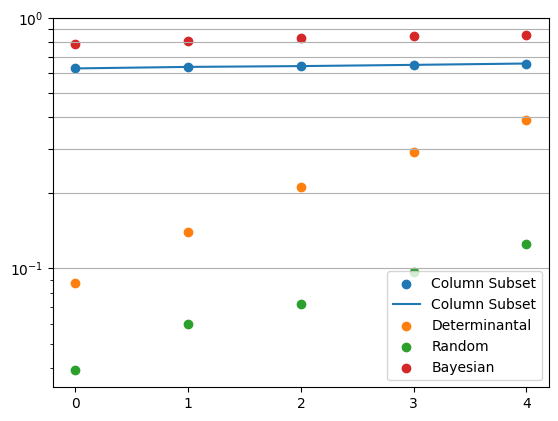

In [ ]:
plt.scatter([0,1,2,3,4], bound_col, label = "Column Subset")
plt.plot([0,1,2,3,4], bound_col, label = "Column Subset")
plt.scatter([0,1,2,3,4], bound_det, label = "Determinantal")
plt.scatter([0,1,2,3,4], bound_rand, label = "Random")
plt.scatter([0,1,2,3,4], bound_bay, label = "Bayesian")
plt.yscale("log")
plt.legend()
plt.xticks([0,1,2,3,4])
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.grid(axis='y')

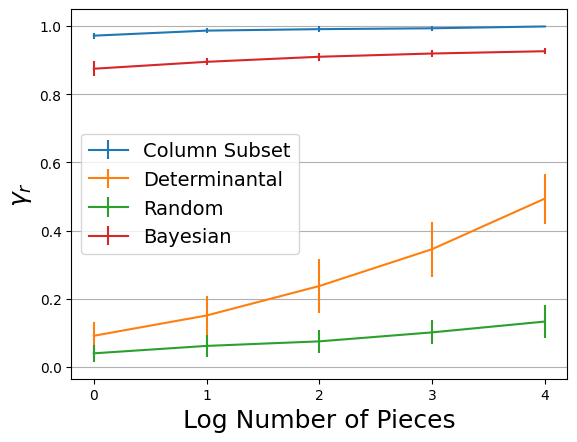

In [ ]:
plt.errorbar([0,1,2,3,4], gammas_col[0,:,:].mean(dim=0), yerr = gammas_col[0,:,:].std(dim=0), label = "Column Subset")
plt.errorbar([0,1,2,3,4], gammas_det[0,:,:].mean(dim=0), yerr = gammas_det[0,:,:].std(dim=0),label = "Determinantal")
plt.errorbar([0,1,2,3,4], gammas_rand[0,:,:].mean(dim=0), yerr = gammas_rand[0,:,:].std(dim=0),label = "Random")
plt.errorbar([0,1,2,3,4], gammas_bayesian[0,:,:].mean(dim=0), yerr = gammas_bayesian[0,:,:].std(dim=0),label = "Bayesian")

# plt.scatter([0,1,2,3,4], gammas_col[0,:,:].mean(dim=0), c = "b", label = "Column Subset", marker = "v")
# # plt.axhline(y = alphas_col[0,:,0].mean(), label = "Column Subset")
# plt.scatter([0,1,2,3,4], alphas_det[0,:,:].mean(dim=0), color = "orange", label = "Determinantal", marker = "v")
# # plt.axhline(y = alphas_det[0,:,0].mean(), color = "orange", label = "Determinantal")
# plt.scatter([0,1,2,3,4], alphas_rand[0,:,:].mean(dim=0), c = "g", label = "Random", marker = "v")
# # plt.axhline(y = alphas_rand[0,:,0].mean(), color = "g", label = "Random")
# plt.scatter([0,1,2,3,4], alphas_bayesian[0,:,:].mean(dim=0), c = "r", label = "Bayesian", marker = "v")
# # plt.axhline(y = alphas_bayesian[0,:,0].mean(), color = "r", label = "Bayesian")
# plt.yscale("log")
plt.legend(fontsize=14)
plt.xlabel("")
plt.xticks([0,1,2,3,4])
plt.grid(axis='y')
plt.xlabel("Log Number of Pieces", fontsize=18)
plt.ylabel(r"$\gamma_r$", fontsize=18)
plt.savefig("gamma-k.pdf", dpi = 300, facecolor = "white", bbox_inches="tight")

In [ ]:
alphas_col = torch.load("drive/MyDrive/JIM/alpha-ks-column-8.pt")
alphas_rand = torch.load("drive/MyDrive/JIM/alpha-ks-random-8.pt")
alphas_det = torch.zeros_like(alphas_col) #torch.load("drive/MyDrive/JIM/alpha-ks-determinantal-8.pt")
alphas_bayesian = torch.load("drive/MyDrive/JIM/alpha-ks-bayesian-8.pt")

# gammas

In [ ]:
plt.scatter([1,2,3,4], alphas_col[0,:,:4].mean(dim=0), label = "Column Subset")
plt.axhline(y = alphas_col[0,:,0].mean(), label = "Column Subset")
plt.scatter([1,2,3,4], alphas_det[0,:,:4].mean(dim=0), label = "Determinantal")
plt.axhline(y = alphas_det[0,:,0].mean(), color = "orange", label = "Determinantal")
plt.scatter([1,2,3,4], alphas_rand[0,:,:4].mean(dim=0), label = "Random")
plt.axhline(y = alphas_rand[0,:,0].mean(), color = "g", label = "Random")
plt.scatter([1,2,3,4], alphas_bayesian[0,:,:4].mean(dim=0), label = "Bayesian")
plt.axhline(y = alphas_bayesian[0,:,0].mean(), color = "r", label = "Bayesian")
plt.xlabel("Rank", fontsize = 16)
plt.ylabel(r"$\alpha$", fontsize = 16)
plt.legend()
# plt.title("Column Function", fontsize = 16)

In [ ]:
n = 8
r = 4
f = make_monotone(torch.randn(2**n))
fr = calc_low_rank_approx(f,r, sub = True)[1]
print(torch.norm(f-fr)/torch.norm(f))

In [ ]:
print(torch.norm(f-fr)/torch.norm(f))

In [ ]:
alphas = torch.zeros(8,5,8)

for n in range(8,10):
  for iter in range(5):
    X = torch.rand(n,n)
    Sigma = X.mm(X.t())
    sigma = 1
    f = determinantal(X.mm(X.t()), sigma)

    alphas[n-8,iter,0] = calc_alpha(f)

    for k in range(1,6):
      alphas[n-8,iter,k] = calc_alpha_restricted(f,k)
    
    print(alphas[n-8,iter,:])

  torch.save(alphas,"drive/MyDrive/JIM/alphas-determinantal-"+str(n)+".pt")


In [ ]:
gammas = torch.zeros(1,5,5)

for n in range(8,9):
  for iter in range(5):
    X = torch.randn(60,n)
    beta = 0.1
    sigma = 0.1
    f = bayesian_A_optimality(X,beta,sigma,n)

    gammas[n-8,iter,0] = calc_gamma(f)

    for k in range(1,5):
      gammas[n-8,iter,k] = calc_gamma_restricted(f,k)
    
    print(gammas[n-8,iter,:])

  torch.save(gammas,"drive/MyDrive/JIM/gamma-ks-bayesian-"+str(n)+".pt")

In [ ]:
gammas = torch.zeros(1,5,5)

for n in range(8,9):
  for iter in range(5):
    X = torch.rand(n,n)
    Sigma = X.mm(X.t())
    sigma = 1
    f = determinantal(X.mm(X.t()), sigma,n)

    gammas[n-8,iter,0] = calc_gamma(f)

    for k in range(1,5):
      gammas[n-8,iter,k] = calc_gamma_restricted(f,k)
    
    print(gammas[n-8,iter,:])

  torch.save(gammas,"drive/MyDrive/JIM/gamma-ks-determinantal-"+str(n)+".pt")

In [ ]:
gammas = torch.zeros(1,5,5)

for n in range(8,9):
  for iter in range(5):
    f = make_monotone(torch.rand(2**n))

    gammas[n-8,iter,0] = calc_gamma(f)

    for k in range(1,5):
      gammas[n-8,iter,k] = calc_gamma_restricted(f,k)
    
    print(gammas[n-8,iter,:])

  torch.save(gammas,"drive/MyDrive/JIM/gamma-ks-random-"+str(n)+".pt")

In [ ]:
gammas = torch.zeros(1,5,5)

for n in range(8,9):
  for iter in range(5):
    f = column_subset_problem(20,n,n)

    gammas[n-8,iter,0] = calc_gamma(f)

    for k in range(1,5):
      gammas[n-8,iter,k] = calc_gamma_restricted(f,k)
    
    print(gammas[n-8,iter,:])

  torch.save(gammas,"drive/MyDrive/JIM/gamma-ks-column-"+str(n)+".pt")

In [ ]:
alphas = torch.zeros(1,5,5)

for n in range(8,9):
  for iter in range(5):
    X = torch.randn(60,n)
    beta = 0.1
    sigma = 0.1
    f = bayesian_A_optimality(X,beta,sigma,n)

    alphas[n-8,iter,0] = calc_alpha(f)

    for k in range(1,5):
      alphas[n-8,iter,k] = calc_alpha_restricted(f,k)
    
    print(alphas[n-8,iter,:])

  torch.save(alphas,"drive/MyDrive/JIM/alpha-ks-bayesian-"+str(n)+".pt")

In [ ]:
alphas = torch.zeros(1,5,5)

for n in range(8,9):
  for iter in range(5):
    f = column_subset_problem(20,n,n)

    alphas[n-8,iter,0] = calc_alpha(f)

    for k in range(1,5):
      alphas[n-8,iter,k] = calc_alpha_restricted(f,k)
    
    print(alphas[n-8,iter,:])

  torch.save(alphas,"drive/MyDrive/JIM/alpha-ks-column-"+str(n)+".pt")

In [ ]:
alphas = torch.zeros(1,5,5)

for n in range(8,9):
  for iter in range(5):
    f = make_monotone(torch.randn(2**n))

    alphas[n-8,iter,0] = calc_alpha(f)

    for k in range(1,5):
      alphas[n-8,iter,k] = calc_alpha_restricted(f,k)
    
    print(alphas[n-8,iter,:])

  torch.save(alphas,"drive/MyDrive/JIM/alpha-ks-random-"+str(n)+".pt")

In [ ]:
optimal, greedy, low_rank_greedy, split_greedy, low_rank_split_greedy = torch.load("drive/MyDrive/JIM/column/results-9.pt")

In [ ]:
greedy[1,:]

In [ ]:
datanames = ["determinantal", "bayesian", "random", "column"]

greedy_opt = torch.zeros(4)
greedy_low_rank_improve = torch.zeros(4,6)
greedy_low_rank_opt = torch.zeros(4,6)

split_1_greedy_opt = torch.zeros(4)
split_1_greedy_low_rank_improve = torch.zeros(4,6)
split_1_greedy_low_rank_opt = torch.zeros(4,6)

split_2_greedy_opt = torch.zeros(4)
split_2_greedy_low_rank_improve = torch.zeros(4,6)
split_2_greedy_low_rank_opt = torch.zeros(4,6)

split_3_greedy_opt = torch.zeros(4)
split_3_greedy_low_rank_improve = torch.zeros(4,6)
split_3_greedy_low_rank_opt = torch.zeros(4,6)

idx = 1
T = 10

for i,name in enumerate(datanames):
  optimal, greedy, low_rank_greedy, split_greedy, low_rank_split_greedy = torch.load("drive/MyDrive/JIM/"+name+"/results-9.pt")

  greedy_opt[i] = (optimal[idx,-1,:] == greedy[idx,:]).sum()/T
  split_1_greedy_opt[i] = (optimal[idx,-1,:] == split_greedy[idx,0,:]).sum()/T
  split_2_greedy_opt[i] = (optimal[idx,-1,:] == split_greedy[idx,1,:]).sum()/T
  split_3_greedy_opt[i] = (optimal[idx,-1,:] == split_greedy[idx,2,:]).sum()/T

  for j in range(6):
    greedy_low_rank_opt[i,j] = (optimal[idx,-1,:] == low_rank_greedy[idx,j,:]).sum()/T
    split_1_greedy_low_rank_opt[i,j] = (optimal[idx,-1,:] == low_rank_split_greedy[idx,j,0,:]).sum()/T
    split_2_greedy_low_rank_opt[i,j] = (optimal[idx,-1,:] == low_rank_split_greedy[idx,j,1,:]).sum()/T
    split_3_greedy_low_rank_opt[i,j] = (optimal[idx,-1,:] == low_rank_split_greedy[idx,j,2,:]).sum()/T

    greedy_low_rank_improve[i,j] = (greedy[idx,:] / low_rank_greedy[idx,j,:]).sum()/T
    split_1_greedy_low_rank_improve[i,j] = (split_greedy[idx,0,:] / low_rank_split_greedy[idx,j,0,:]).sum()/T
    split_2_greedy_low_rank_improve[i,j] = (split_greedy[idx,1,:] / low_rank_split_greedy[idx,j,1,:]).sum()/T
    split_3_greedy_low_rank_improve[i,j] = (split_greedy[idx,2,:] / low_rank_split_greedy[idx,j,2,:]).sum()/T



In [ ]:
N = 3
plt.scatter(range(6),greedy_low_rank_improve[N,:], label = "Greedy", color = "r")
plt.scatter(range(6),split_1_greedy_low_rank_improve[N,:], label = "1 Split Greedy", color = "g")
plt.scatter(range(6),split_2_greedy_low_rank_improve[N,:], label = "2 Split Greedy", color = "b")
plt.scatter(range(6),split_3_greedy_low_rank_improve[N,:], label = "3 Split Greedy", color = "orange")
plt.xlabel("Rank")
plt.ylabel("ratio of original to approx")
plt.title(datanames[N])
plt.legend()

In [ ]:
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))


br1 = np.arange(4)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

r = 5

plt.bar(br1, greedy_low_rank_opt[:,r], color ='r', width = barWidth,
        edgecolor ='grey', label ='Greedy')
plt.bar(br2, split_1_greedy_low_rank_opt[:,r], color ='g', width = barWidth,
        edgecolor ='grey', label ='1 Split Greedy')
plt.bar(br3, split_2_greedy_low_rank_opt[:,r], color ='b', width = barWidth,
        edgecolor ='grey', label ='2 Split Greedy')
plt.bar(br4, split_3_greedy_low_rank_opt[:,r], color ='orange', width = barWidth,
        edgecolor ='grey', label ='3 Split Greedy')

plt.xlabel('Datasets. Here n = 9, rank '+str(r), fontweight ='bold', fontsize = 15)
plt.ylabel('Percentage of Times Optimal is Found', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(4)],
        ['Determinantal', 'Bayesian', 'Random', 'Column'])
 
plt.legend()
plt.show()

In [ ]:
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))


br1 = np.arange(4)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

plt.bar(br1, greedy_opt, color ='r', width = barWidth,
        edgecolor ='grey', label ='Greedy')
plt.bar(br2, split_1_greedy_opt, color ='g', width = barWidth,
        edgecolor ='grey', label ='1 Split Greedy')
plt.bar(br3, split_2_greedy_opt, color ='b', width = barWidth,
        edgecolor ='grey', label ='2 Split Greedy')
plt.bar(br4, split_3_greedy_opt, color ='orange', width = barWidth,
        edgecolor ='grey', label ='3 Split Greedy')

plt.xlabel('Datasets. Here n = 9', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentage of Times Optimal is Found', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(4)],
        ['Determinantal', 'Bayesian', 'Random', 'Column'])
 
plt.legend()
plt.show()

In [ ]:
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))


br1 = np.arange(4)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

plt.bar(br1, greedy_percentage, color ='r', width = barWidth,
        edgecolor ='grey', label ='Greedy')
plt.bar(br2, split_1_greedy, color ='g', width = barWidth,
        edgecolor ='grey', label ='1 Split Greedy')
plt.bar(br3, split_2_greedy, color ='b', width = barWidth,
        edgecolor ='grey', label ='2 Split Greedy')
plt.bar(br4, split_3_greedy, color ='orange', width = barWidth,
        edgecolor ='grey', label ='3 Split Greedy')

plt.xlabel('Datasets. Here n = 9', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentage of Times Optimal is Found', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(4)],
        ['Determinantal', 'Bayesian', 'Random', 'Column'])
 
plt.legend()
plt.show()

In [ ]:
from time import time

ns = [7]
rs = [0,1,2,3,4,5,6]
T = 50

error = torch.zeros(len(rs),T)
times = torch.zeros(len(rs),T)

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    X = torch.rand(n,2*n)
    Sigma = X.mm(X.t())
    sigma = 0.1
    f = determinantal(X.mm(X.t()), sigma, n)
    f /= f.max()
    for r in rs:
      t1 = time()
      fr = calc_low_rank_approx(f,r)[1]
      t2 = time()
      error[r,t] = torch.norm(f-fr)/torch.norm(f)
      times[r,t] = t2-t1
      print(error[:,t], times[:,t])
    torch.save((error,times),"drive/MyDrive/JIM/determinantal-low-rank-approximation-n-7.pt")

In [ ]:
from time import time

ns = [7]
rs = [0,1,2,3,4,5,6]
T = 50

error = torch.zeros(len(rs),T)
times = torch.zeros(len(rs),T)

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    f = make_monotone(torch.rand(2**n))
    f /= f.max()
    for r in rs:
      t1 = time()
      fr = calc_low_rank_approx(f,r)[1]
      t2 = time()
      error[r,t] = torch.norm(f-fr)/torch.norm(f)
      times[r,t] = t2-t1
      print(error[:,t], times[:,t])
    torch.save((error,times),"drive/MyDrive/JIM/random-low-rank-approximation-n-7.pt")

In [ ]:
from time import time

ns = [8,9,10,11,12]
rs = [0,1,2]
T = 5

error = torch.zeros(len(ns),len(rs),T)
times = torch.zeros(len(ns),len(rs),T)

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    f = make_monotone(torch.rand(2**n))
    f /= f.max()
    for r in rs:
      t1 = time()
      fr = calc_low_rank_approx(f,r, random = False)[1]
      t2 = time()
      error[i,r,t] = torch.norm(f-fr)/torch.norm(f)
      times[i,r,t] = t2-t1
      print(error[i,:,t], times[i,:,t])
    torch.save((error,times),"drive/MyDrive/JIM/random-low-rank-approximation-n-8-12.pt")

In [ ]:
from time import time

ns = [7]
rs = [0,1,2,3,4,5,6]
T = 50

error = torch.zeros(len(rs),T)
times = torch.zeros(len(rs),T)

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    f = column_subset_problem(60,n,n)
    f /= f.max()
    for r in rs:
      t1 = time()
      fr = calc_low_rank_approx(f,r)[1]
      t2 = time()
      error[r,t] = torch.norm(f-fr)/torch.norm(f)
      times[r,t] = t2-t1
      print(error[:,t], times[:,t])
    torch.save((error,times),"drive/MyDrive/JIM/column-low-rank-approximation-n-7.pt")

In [ ]:
from time import time

ns = [7]
rs = [0,1,2,3,4,5,6]
T = 50

error = torch.zeros(len(rs),T)
times = torch.zeros(len(rs),T)

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    X = torch.randn(60,n)
    beta = 1
    sigma = 0.01
    f = bayesian_A_optimality(X,beta,sigma,n)
    f /= f.max()
    for r in rs:
      t1 = time()
      fr = calc_low_rank_approx(f,r)[1]
      t2 = time()
      error[r,t] = torch.norm(f-fr)/torch.norm(f)
      times[r,t] = t2-t1
      print(error[:,t], times[:,t])
    torch.save((error,times),"drive/MyDrive/JIM/bayesian-low-rank-approximation-n-7.pt")

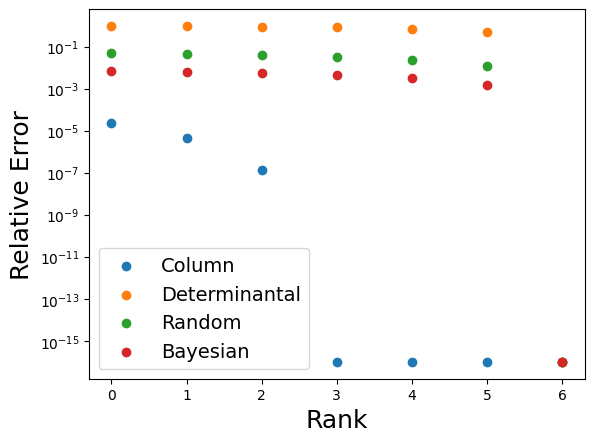

In [ ]:
error_d, time_d = torch.load("drive/MyDrive/JIM/determinantal-low-rank-approximation-n-7.pt")
error_r, time_r = torch.load("drive/MyDrive/JIM/random-low-rank-approximation-n-7.pt")
error_c, time_c = torch.load("drive/MyDrive/JIM/column-low-rank-approximation-n-7.pt")
error_b, time_b = torch.load("drive/MyDrive/JIM/bayesian-low-rank-approximation-n-7.pt")
rs = [0,1,2,3,4,5,6]


plt.scatter(rs, error_c.mean(dim=1)+1e-16, label = "Column")
plt.scatter(rs, error_d.mean(dim=1)+1e-16, label = "Determinantal")
plt.scatter(rs, error_r.mean(dim=1)+1e-16, label = "Random")
plt.scatter(rs, error_b.mean(dim=1)+1e-16, label = "Bayesian")
plt.yscale("log")
plt.xlabel("Rank", fontsize=18)
plt.ylabel("Relative Error", fontsize=18)
plt.legend(fontsize=14)
plt.savefig("error.pdf", dpi = 300, bbox_inches = "tight", facecolor="white")

In [ ]:
ns = [15,20]
T = 50
splits = [1,2,3]

optimal = torch.zeros(len(ns),T)
greedy = torch.zeros(len(ns),T)
split_greedy = torch.zeros(len(ns),len(splits),T)

M = 10

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    X = torch.rand(n,2*n)
    Sigma = X.mm(X.t())
    sigma = 0.1
    f = determinantal(X.mm(X.t()), sigma, M)
    # f /= f.max()

    greedy[i,t] = greedy_size_constraint(f,0,M,n)[1].item()
    order = make_order(n,M)
    idx = order[f[order].argmax()]
    optimal[i,t] = f[idx]

    for s in splits:
        split_greedy[i,s-1,t] =  f[modified_greedy_constrained(f,M,s,n)[1]]

        print(optimal[i,t],greedy[i,t],split_greedy[i,s-1,t])

    # for r in rs:
    #   fr = calc_low_rank_approx(f,r)[1]

    #   print(torch.norm(f-fr))

    #   order = make_order(n,5)
    #   idx = order[fr[order].argmax()]
    #   optimal[n-8,r,t] = f[idx]

    #   low_rank_greedy[n-8,r,t] = f[greedy_size_constraint(fr,0,5,n)[0]]
      
    #   for s in splits:
    #     low_rank_split_greedy[n-8,r,s-1,t] =  f[modified_greedy_constrained(fr,5,s,n)[1]]

    #     print(optimal[n-8,r,t],low_rank_greedy[n-8,r,t],low_rank_split_greedy[n-8,r,s-1,t])

  # torch.save((optimal, greedy, low_rank_greedy, split_greedy, low_rank_split_greedy),"drive/MyDrive/JIM/determinantal/results-"+str(n)+".pt")
  torch.save((optimal, greedy, low_rank_greedy, split_greedy, low_rank_split_greedy),"drive/MyDrive/JIM/determinantal/larger-results-"+str(n)+".pt")

In [ ]:
ns = [15,20]
T = 50
splits = [1,2,3]

optimal = torch.zeros(len(ns),T)
greedy = torch.zeros(len(ns),T)
split_greedy = torch.zeros(len(ns),len(splits),T)

M = 10

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    X = torch.randn(60,n)
    beta = 1
    sigma = 0.01
    f = bayesian_A_optimality(X,beta,sigma,M)
    # f /= f.max()

    greedy[i,t] = greedy_size_constraint(f,0,M,n)[1].item()
    order = make_order(n,M)
    idx = order[f[order].argmax()]
    optimal[i,t] = f[idx]

    for s in splits:
        split_greedy[i,s-1,t] =  f[modified_greedy_constrained(f,M,s,n)[1]]

        print(optimal[i,t],greedy[i,t],split_greedy[i,s-1,t])

    # for r in rs:
    #   fr = calc_low_rank_approx(f,r)[1]

    #   print(torch.norm(f-fr))

    #   order = make_order(n,5)
    #   idx = order[fr[order].argmax()]
    #   optimal[n-8,r,t] = f[idx]

    #   low_rank_greedy[n-8,r,t] = f[greedy_size_constraint(fr,0,5,n)[0]]
      
    #   for s in splits:
    #     low_rank_split_greedy[n-8,r,s-1,t] =  f[modified_greedy_constrained(fr,5,s,n)[1]]

    #     print(optimal[n-8,r,t],low_rank_greedy[n-8,r,t],low_rank_split_greedy[n-8,r,s-1,t])

  # torch.save((optimal, greedy, low_rank_greedy, split_greedy, low_rank_split_greedy),"drive/MyDrive/JIM/determinantal/results-"+str(n)+".pt")
  torch.save((optimal, greedy, split_greedy),"drive/MyDrive/JIM/bayesian/larger-results-"+str(n)+".pt")

In [ ]:
ns = [15,20]
T = 50
splits = [1,2,3]

optimal = torch.zeros(len(ns),T)
greedy = torch.zeros(len(ns),T)
split_greedy = torch.zeros(len(ns),len(splits),T)

M = 10

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    f = make_monotone(torch.randn(2**n))
    # f /= f.max()

    greedy[i,t] = greedy_size_constraint(f,0,M,n)[1].item()
    order = make_order(n,M)
    idx = order[f[order].argmax()]
    optimal[i,t] = f[idx]

    for s in splits:
        split_greedy[i,s-1,t] =  f[modified_greedy_constrained(f,M,s,n)[1]]

        print(optimal[i,t],greedy[i,t],split_greedy[i,s-1,t])

    # for r in rs:
    #   fr = calc_low_rank_approx(f,r)[1]

    #   print(torch.norm(f-fr))

    #   order = make_order(n,5)
    #   idx = order[fr[order].argmax()]
    #   optimal[n-8,r,t] = f[idx]

    #   low_rank_greedy[n-8,r,t] = f[greedy_size_constraint(fr,0,5,n)[0]]
      
    #   for s in splits:
    #     low_rank_split_greedy[n-8,r,s-1,t] =  f[modified_greedy_constrained(fr,5,s,n)[1]]

    #     print(optimal[n-8,r,t],low_rank_greedy[n-8,r,t],low_rank_split_greedy[n-8,r,s-1,t])

  # torch.save((optimal, greedy, low_rank_greedy, split_greedy, low_rank_split_greedy),"drive/MyDrive/JIM/determinantal/results-"+str(n)+".pt")
  torch.save((optimal, greedy, split_greedy),"drive/MyDrive/JIM/random/larger-results-"+str(n)+".pt")

In [ ]:
ns = [15,20]
T = 50
splits = [1,2,3]

optimal = torch.zeros(len(ns),T)
greedy = torch.zeros(len(ns),T)
split_greedy = torch.zeros(len(ns),len(splits),T)

M = 10

for i,n in enumerate(ns):
  for t in tqdm(range(T)):
    f = column_subset_problem(40,n,M)
    # f /= f.max()

    greedy[i,t] = greedy_size_constraint(f,0,M,n)[1].item()
    order = make_order(n,M)
    idx = order[f[order].argmax()]
    optimal[i,t] = f[idx]

    for s in splits:
        split_greedy[i,s-1,t] =  f[modified_greedy_constrained(f,M,s,n)[1]]

        print(optimal[i,t],greedy[i,t],split_greedy[i,s-1,t])

    # for r in rs:
    #   fr = calc_low_rank_approx(f,r)[1]

    #   print(torch.norm(f-fr))

    #   order = make_order(n,5)
    #   idx = order[fr[order].argmax()]
    #   optimal[n-8,r,t] = f[idx]

    #   low_rank_greedy[n-8,r,t] = f[greedy_size_constraint(fr,0,5,n)[0]]
      
    #   for s in splits:
    #     low_rank_split_greedy[n-8,r,s-1,t] =  f[modified_greedy_constrained(fr,5,s,n)[1]]

    #     print(optimal[n-8,r,t],low_rank_greedy[n-8,r,t],low_rank_split_greedy[n-8,r,s-1,t])

  # torch.save((optimal, greedy, low_rank_greedy, split_greedy, low_rank_split_greedy),"drive/MyDrive/JIM/determinantal/results-"+str(n)+".pt")
  torch.save((optimal, greedy, split_greedy),"drive/MyDrive/JIM/column/larger-results-"+str(n)+".pt")

In [ ]:
ns = [8,9,10]
rs = [0,1,2,3,4,5]
T = 10
splits = [1,2,3]

optimal = torch.zeros(3,7,T)
greedy = torch.zeros(3,10)
low_rank_greedy = torch.zeros(3,6,T)
split_greedy = torch.zeros(3,3,T)
low_rank_split_greedy = torch.zeros(3,6,3,T)



for n in ns:
  for t in range(T):
    X = torch.randn(60,n)
    beta = 1
    sigma = 0.01
    f = bayesian_A_optimality(X,beta,sigma)
    f /= f.max()

    greedy[n-8,t] = greedy_size_constraint(f,0,5,n)[1].item()
    order = make_order(n,5)
    idx = order[f[order].argmax()]
    optimal[n-8,-1,t] = f[idx]

    for s in splits:
        split_greedy[n-8,s-1,t] =  f[modified_greedy_constrained(f,5,s,n)[1]]

        print(optimal[n-8,-1,t],greedy[n-8,t],split_greedy[n-8,s-1,t])

    for r in rs:
      fr = calc_low_rank_approx(f,r)[1]

      print(torch.norm(f-fr))

      order = make_order(n,5)
      idx = order[fr[order].argmax()]
      optimal[n-8,r,t] = f[idx]

      low_rank_greedy[n-8,r,t] = f[greedy_size_constraint(fr,0,5,n)[0]]
      
      for s in splits:
        low_rank_split_greedy[n-8,r,s-1,t] =  f[modified_greedy_constrained(fr,5,s,n)[1]]

        print(optimal[n-8,r,t],low_rank_greedy[n-8,r,t],low_rank_split_greedy[n-8,r,s-1,t])

  torch.save((optimal, greedy, low_rank_greedy, split_greedy, low_rank_split_greedy),"drive/MyDrive/JIM/bayesian/results-"+str(n)+".pt")

In [ ]:
ns = [8,9,10]
rs = [0,1,2,3,4,5]
T = 10
splits = [1,2,3]

optimal = torch.zeros(3,7,T)
greedy = torch.zeros(3,10)
low_rank_greedy = torch.zeros(3,6,T)
split_greedy = torch.zeros(3,3,T)
low_rank_split_greedy = torch.zeros(3,6,3,T)

for n in ns:
  for t in range(T):
    f = make_monotone(torch.randn(2**n))
    f /= f.max()

    greedy[n-8,t] = greedy_size_constraint(f,0,5,n)[1].item()
    order = make_order(n,5)
    idx = order[f[order].argmax()]
    optimal[n-8,-1,t] = f[idx]

    for s in splits:
        split_greedy[n-8,s-1,t] =  f[modified_greedy_constrained(f,5,s,n)[1]]

        print(optimal[n-8,-1,t],greedy[n-8,t],split_greedy[n-8,s-1,t])

    for r in rs:
      fr = calc_low_rank_approx(f,r)[1]

      print(torch.norm(f-fr))

      order = make_order(n,5)
      idx = order[fr[order].argmax()]
      optimal[n-8,r,t] = f[idx]

      low_rank_greedy[n-8,r,t] = f[greedy_size_constraint(fr,0,5,n)[0]]
      
      for s in splits:
        low_rank_split_greedy[n-8,r,s-1,t] =  f[modified_greedy_constrained(fr,5,s,n)[1]]

        print(optimal[n-8,r,t],low_rank_greedy[n-8,r,t],low_rank_split_greedy[n-8,r,s-1,t])

  torch.save((optimal, greedy, low_rank_greedy, split_greedy, low_rank_split_greedy),"drive/MyDrive/JIM/random/results-"+str(n)+".pt")

In [ ]:
ns = [8,9,10]
rs = [0,1,2,3,4,5]
T = 10
splits = [1,2,3]

optimal = torch.zeros(3,7,T)
greedy = torch.zeros(3,10)
low_rank_greedy = torch.zeros(3,6,T)
split_greedy = torch.zeros(3,3,T)
low_rank_split_greedy = torch.zeros(3,6,3,T)



for n in ns:
  for t in range(T):
    f = column_subset_problem(40,n)
    f /= f.max()

    greedy[n-8,t] = greedy_size_constraint(f,0,5,n)[1].item()
    order = make_order(n,5)
    idx = order[f[order].argmax()]
    optimal[n-8,-1,t] = f[idx]

    for s in splits:
        split_greedy[n-8,s-1,t] =  f[modified_greedy_constrained(f,5,s,n)[1]]

        print(optimal[n-8,-1,t],greedy[n-8,t],split_greedy[n-8,s-1,t])

    for r in rs:
      fr = calc_low_rank_approx(f,r)[1]

      print(torch.norm(f-fr))

      order = make_order(n,5)
      idx = order[fr[order].argmax()]
      optimal[n-8,r,t] = f[idx]

      low_rank_greedy[n-8,r,t] = f[greedy_size_constraint(fr,0,5,n)[0]]
      
      for s in splits:
        low_rank_split_greedy[n-8,r,s-1,t] =  f[modified_greedy_constrained(fr,5,s,n)[1]]

        print(optimal[n-8,r,t],low_rank_greedy[n-8,r,t],low_rank_split_greedy[n-8,r,s-1,t])

  torch.save((optimal, greedy, low_rank_greedy, split_greedy, low_rank_split_greedy),"drive/MyDrive/JIM/column/results-"+str(n)+".pt")

In [ ]:
n = 500
# f = make_monotone(torch.randn(2**n))
# f = column_subset_problem(10,n)

# X = torch.randn(60,n)
# beta = 0.1
# sigma = 0.1
# f = bayesian_A_optimality(X,beta,sigma)

X = torch.rand(n,n)
Sigma = X.mm(X.t())
sigma = 1
# f = determinantal(X.mm(X.t()), sigma)

# for i in range(2**n):
#   print(format(i,"0"+str(n)+"b"), f[i])

In [ ]:
check_monotone(f)

In [ ]:
f[0]

In [ ]:
calc_gamma(f)

In [ ]:
for k in range(1,6):
  print(calc_gamma_restricted(f,k))

In [ ]:
calc_alpha(f)

In [ ]:
for k in range(1,6):
  print(calc_alpha_restricted(f,k))

In [ ]:
f.shape

In [ ]:
f.argmax()

In [ ]:
order = make_order(n,5)
order[torch.tensor([determinantal_f(x) for x in order]).argmax()]

In [ ]:
greedy_size_constraint(bayesian_A_optimality_f,0,15,n)

In [ ]:
modified_greedy_constrained(bayesian_A_optimality_f,15,1,n)

In [ ]:
modified_greedy_constrained(bayesian_A_optimality_f,15,2,n)

In [ ]:
greedy_size_constraint(determinantal_f,0,15,n)

In [ ]:
modified_greedy_constrained(determinantal_f,15,1,n)

In [ ]:
modified_greedy_constrained(determinantal_f,15,2,n)

In [ ]:
greedy_size_constraint(determinantal_f,0,15,n)

In [ ]:
modified_greedy_constrained(determinantal_f,15,1,n)

In [ ]:
modified_greedy_constrained(determinantal_f,15,2,n)

In [ ]:
Ns = [25,50,75,100,150,200,250,300,400,500]

greedy = torch.zeros(10,100)
greedy_1 = torch.zeros(10,100)
greedy_2 = torch.zeros(10,100)
greedy_m1 = torch.zeros(10,100)
greedy_m2 = torch.zeros(10,100)


for idx,n in enumerate(Ns):
  for trial in tqdm(range(100)):
    X = torch.rand(n,n)
    Sigma = X.mm(X.t())
    sigma = 1
    greedy[idx,trial] = greedy_size_constraint(determinantal_f,0,15,n)[1]
    greedy_1[idx,trial] = modified_greedy_constrained(determinantal_f,15,1,n)[0]
    # greedy_2[idx,trial] = modified_greedy_constrained(determinantal_f,15,2,n)[0]
    greedy_m1[idx,trial] = more_compute_greedy_constrained(determinantal_f,15,1,n)[0]
    # greedy_m2[idx,trial] = more_compute_greedy_constrained(determinantal_f,15,2,n)[0]

  print(greedy[idx,:].mean(),greedy_1[idx,:].mean(),greedy_m1[idx,:].mean(),(greedy_1[idx,:]/greedy_m1[idx,:]).mean())

  torch.save(greedy,"drive/MyDrive/JIM/greedy-determinantal"+str(n)+"-15.pt")
  torch.save(greedy_1,"drive/MyDrive/JIM/modified-greedy-1-determinantal-"+str(n)+"-15.pt")
  # torch.save(greedy_2,"drive/MyDrive/JIM/modified-greedy-2-determinantal-"+str(n)+"-15.pt")
  torch.save(greedy_m1,"drive/MyDrive/JIM/compute-greedy-1-determinantal-"+str(n)+"-15.pt")
  # torch.save(greedy_m2,"drive/MyDrive/JIM/compute-greedy-2-determinantal"+str(n)+"-15.pt")




100%|██████████| 100/100 [06:09<00:00,  3.70s/it]


tensor(2.8798e+08) tensor(3.0353e+08) tensor(3.0353e+08) tensor(1.)


100%|██████████| 100/100 [28:27<00:00, 17.08s/it]


tensor(2.8114e+12) tensor(3.1696e+12) tensor(3.1676e+12) tensor(1.0006)


100%|██████████| 100/100 [1:07:28<00:00, 40.49s/it]


tensor(7.4291e+14) tensor(8.4636e+14) tensor(8.4625e+14) tensor(1.0002)


100%|██████████| 100/100 [2:05:49<00:00, 75.49s/it]


tensor(3.9839e+16) tensor(4.6090e+16) tensor(4.6070e+16) tensor(1.0005)


100%|██████████| 100/100 [5:03:01<00:00, 181.81s/it]


tensor(1.2049e+19) tensor(1.3941e+19) tensor(1.3932e+19) tensor(1.0006)


100%|██████████| 100/100 [9:20:43<00:00, 336.44s/it]


tensor(7.2983e+20) tensor(8.1869e+20) tensor(8.1854e+20) tensor(1.0002)


 17%|█▋        | 17/100 [2:44:49<13:24:45, 581.75s/it]


KeyboardInterrupt: ignored

In [ ]:
(greedy_1[1,:]/greedy_m1[1,:]).sort()

torch.return_types.sort(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0098, 1.0175,
        1.0326]),
indices=tensor([60, 73, 72, 71, 70, 69, 67, 66, 65, 64, 63, 62, 61, 74

In [ ]:
(greedy_1[2,:]/greedy_m1[2,:]).sort()

torch.return_types.sort(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0007,
        1.0146]),
indices=tensor([62, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 76

In [ ]:
(greedy_1[3,:]/greedy_m1[3,:]).sort()

torch.return_types.sort(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0013, 1.0022, 1.0097, 1.0129,
        1.0192]),
indices=tensor([61, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 74

In [ ]:
(greedy_1[4,:]/greedy_m1[4,:]).sort()

torch.return_types.sort(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0030, 1.0062, 1.0164, 1.0174,
        1.0215]),
indices=tensor([60, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 73

In [ ]:
(greedy_1[5,:]/greedy_m1[5,:]).sort()

torch.return_types.sort(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0006, 1.0015,
        1.0139]),
indices=tensor([61, 74, 73, 72, 71, 69, 68, 67, 66, 65, 64, 63, 62, 75

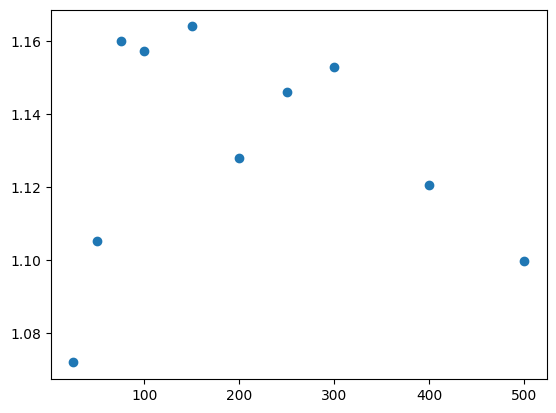

In [ ]:
import torch
Ns = [25,50,75,100,150,200,250,300,400,500]
ratios_d = torch.zeros(len(Ns))
rerrors_d = torch.zeros(len(Ns))
for i,n in enumerate(Ns):
  greedy = torch.load("drive/MyDrive/JIM/greedy-determinantal-"+str(n)+"-15.pt")
  greedy_1 = torch.load("drive/MyDrive/JIM/modified-greedy-1-determinantal-"+str(n)+"-15.pt")

  ratios_d[i] = (greedy_1[0,:]/greedy[0,:]).mean()
  rerrors_d[i] = (greedy_1[0,:]/greedy[0,:]).std()

plt.scatter(Ns, ratios_d)

In [ ]:
import torch
Ns = [25,50,75,100,150,200,250,300,400,500]
ratios_b = torch.zeros(len(Ns))
rerrors_b = torch.zeros(len(Ns))
for i,n in enumerate(Ns):
  greedy = torch.load("drive/MyDrive/JIM/greedy-bayesian-"+str(n)+"-15.pt")
  greedy_1 = torch.load("drive/MyDrive/JIM/modified-greedy-1-bayesian-"+str(n)+"-15.pt")

  ratios_b[i] = (greedy_1[i,:]/greedy[i,:]).mean()
  rerrors_b[i] = (greedy_1[i,:]/greedy[i,:]).std()

Text(0, 0.5, 'Ratio of Split Greedy to Greedy')

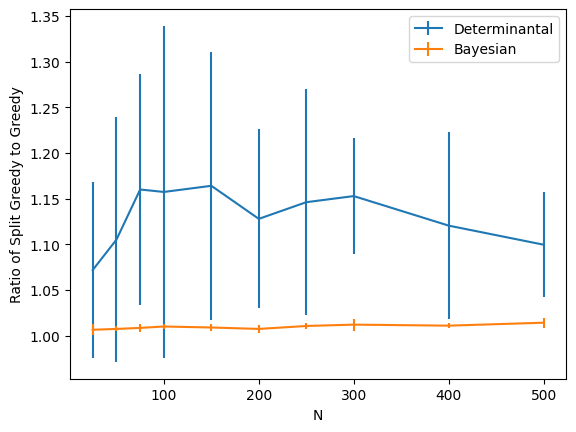

In [ ]:
plt.errorbar(Ns, ratios_d, yerr=rerrors_d, label = "Determinantal")
plt.errorbar(Ns, ratios_b, yerr=rerrors_b, label = "Bayesian")
plt.legend()
plt.xlabel("N")
plt.ylabel("Ratio of Split Greedy to Greedy")

In [ ]:
import torchvision
import torchvision.datasets as data
import torchvision.transforms as Transforms

Tflatten = Transforms.Lambda(lambda x: torch.flatten(x))
Tfloat = Transforms.Lambda(lambda x: x.to(torch.float))

T = Transforms.Compose([Transforms.ToTensor(), Tfloat, Tflatten])

mnist_train = data.MNIST("./", train = True, download = True, transform=T)
# mnist_dataloader = torch.utils.data.DataLoader(mnist_train)
# print("MNIST:", next(iter(mnist_dataloader))[0].shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 81783350.60it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22060771.05it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21829293.87it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3451808.08it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# Ns = [25,50,75,100,150,200,250,300,400,500]
n = 100

greedy = torch.zeros(10,5)
greedy_1 = torch.zeros(10,5)

# idx = 0
# for n in Ns:
#   for trial in tqdm(range(5)):





counts = torch.zeros(10)
keeps = y < -1
for i in range(2*n):
  if counts[y[i]] < 10:
    counts[y[i]] += 1
    keeps[i] = True

print(sum(keeps))
A = A[keeps,:]

Sigma = A.mm(A.t())/(2*n)
sigma = 1

tensor(100)


In [ ]:

idx, greedy_val = greedy_size_constraint(determinantal_f,0,10,n)
greedy_1_val,idx1 = modified_greedy_constrained(determinantal_f,10,2,n)
  # idx+=1

  # print(greedy_1[idx-1,:].mean()/greedy[idx-1,:].mean())

  # torch.save(greedy,"drive/MyDrive/JIM/greedy-bayesian-"+str(n)+"-15.pt")
  # torch.save(greedy_1,"drive/MyDrive/JIM/modified-greedy-1-bayesian-"+str(n)+"-15.pt")




100%|██████████| 4950/4950 [52:18<00:00,  1.58it/s]


In [ ]:
S_1 = format(idx1,"0"+str(n)+"b")
indexes_1 = torch.zeros(n, dtype = torch.long)
idxp = 0
for j in range(n):
  if S_1[j] == "1":
    indexes_1[idxp] = j
    idxp += 1
indexes_1 = indexes_1[:idxp]

S = format(idx,"0"+str(n)+"b")
indexes = torch.zeros(n, dtype = torch.long)
idxp = 0
for j in range(n):
  if S[j] == "1":
    indexes[idxp] = j
    idxp += 1
indexes = indexes[:idxp]

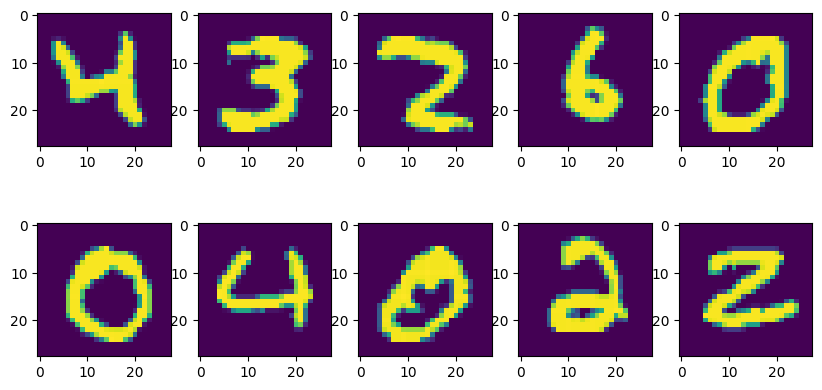

In [ ]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 5), )

gs = GridSpec(nrows=2, ncols=5)
for i in range(2):
  for j in range(5):
    S_idx = i*5+j
    ax = fig.add_subplot(gs[i, j])
    ax.imshow(A[indexes[S_idx],:].reshape(28,28))

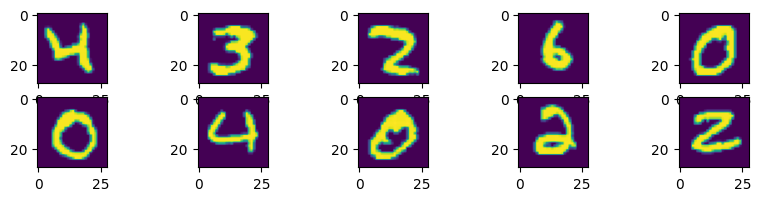

In [ ]:
fig = plt.figure(figsize=(10, 2), )

gs = GridSpec(nrows=2, ncols=5)
for i in range(2):
  for j in range(5):
    S_idx = i*5+j
    ax = fig.add_subplot(gs[i, j])
    ax.imshow(A[indexes_1[S_idx],:].reshape(28,28))

In [ ]:
greedy_1_val/greedy_val

tensor(1.)